# Handwriting Synthesis
This notebook is a personal attempt at coding Alex Graves RNN to predict handwriting (section 5). The paper can be found [here](https://arxiv.org/abs/1308.0850). It is almost the same as the handwriting prediction network (Handwriting prediction - Model 2) but incorporates an attention mechanism so the network learns what character it is writing.

The goal of this notebook is to implement a network in a straightforward manner. As such, code readability is a priority over performance. The implemented network consists of layers of LSTM followed by a Gaussian mixtures layer, with an attention mechanism in between. Handwriting is highly variable. It makes more sense to generate a probability density function at each time step for the next stroke to capture that essence.

The network is tweakable in sequence length, number of mixtures and dropout probability.

The notebook is divided into data treatment (I used [Greydanus's code](https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb) for that as that part is boring, a variation from hardmaru's code) some useful functions, network class, loss function and training. 

The dataset comes from [IAM On-Line Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database). Download data/lineStrokes-all.tar.gz after signing up ! The path should be ./data/lineStrokes if you want to use this notebook.

Enjoy :)

In [1]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import svgwrite
from IPython.display import SVG, display
import matplotlib.cm as cm

import torch
from torch import nn, optim
import torch.nn.functional as F
use_cuda = False
use_cuda = torch.cuda.is_available()

import time
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress

n_batch = 20
sequence_length = 400
U_items = int(sequence_length/25)

hidden_size = 256
n_layers = 3
n_gaussians = 20
Kmixtures = 10

eps = float(np.finfo(np.float32).eps)

# Hyperparameters
gradient_threshold = 10
dropout = 0.2



torch.cuda.empty_cache()

## Dataloader
This code comes from [Greydanus](https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb). Big thanks to his author !

That part is not that fun. Dataloader is a class that parses all the .xml files. It creates a pickle file for future use. It creates a training set containing sequences x, y (same as x but shifted one timestep) and c (one-hot encoding of the sequence) in batches depending on the sequence length. Function `next_batch()` neatly returns a batch. Use `reset_batch_pointer()` to reset the current batch. See the training function for a proper use of that wonderful code. 

In this notebook, we won't use the hot-one vectors as it is used to implement the attention mechanism of section 5 of the paper.

Some examples of training data :

![batch2](./pictures/batch_model2.png)

And some example code to load the data :

```python
x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
```

In [2]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))

        
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data_generation.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print ("creating training data cpkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print ("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print ("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print ("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print ("Loaded dataset:")
        print ("   -> {} individual data points".format(len(self.stroke_data)))
        print ("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print ("pointer reset")

# Utils

Here are a couple of useful functions

`line_plot(strokes, title)`: plots a sequence. Results look like this :

![batch2](./pictures/batch_model2.png)

`one_hot(s)`: transforms a string sequence into a one-hot matrix. Dimensions of the output one-hot matrix are (string length, len(alphabet)). For example :

```python
s = "writing is hard"
print(one_hot(s))
```

`plot_heatmaps(Phis, Ws)`: plots Phis and soft-window heatmaps. It corresponds to the values of equations 46 and 47 of the paper. 

![heatmpas](./pictures/heatmaps.png)
![heatmpas](./pictures/eq46-47.png)

`def get_n_params(model)`: returns the number of parameters of a model

And some example code to load the data :

```python
x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
```



In [3]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def one_hot(s):
    #index position 0 means "unknown"
    alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
    seq = [alphabet.find(char) + 1 for char in s]

    one_hot = np.zeros((len(s),len(alphabet)+1))
    one_hot[np.arange(len(s)),seq] = 1
    return one_hot

def plot_heatmaps(Phis, Ws):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Phis', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("ascii #", fontsize=15)
    
    plt.imshow(Phis, interpolation='nearest', aspect='auto', cmap=cm.jet)
    plt.subplot(122)
    plt.title('Soft attention window', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("one-hot vector", fontsize=15)
    plt.imshow(Ws, interpolation='nearest', aspect='auto', cmap=cm.jet)

    display(plt.gcf())
    

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp





## Model

This is where the fun begins. The network consists of LSTM cells stacked on top of each other and followed by a Gaussian mixture layer with an attention mechanism in between. This network includes skip connections like the paper. It is almost the same network as the one in my other notebook (Handwriting prediction - Model 2) but with the attention mechanism.


`__init__(self, hidden_size = 256, n_gaussians = 10, Kmixtures = 10, dropout = 0.2, alphabet_size = 64)` :
This is the constructor. It takes the different parameters to create the different blocks of the model.
- hidden_size is the size of the output of each LSTM cell
- n_gaussians is the number of mixtures
- Kmixtures is the number of Gaussian functions for the window vectors
- dropout is the dropout probability. It gives the probability to skip a cell during forward propagation. It's not implemented actually
- alphabet_size is the number of characters in our dictionary

The attention mechanisme is implemented between LSTM1 and LSTM2. LSTM1 takes as inputs the window vectors of the previous time step as well as current stroke coordinates. A dense layer is used taking the output of LSTM1 to compute the parameters of the window vectors. The current window vector is passed on to LSTM2 and LSTM3 as well as the stroke coordinates via skip connections. LSTM2 and LSTM3 of course take the hidden vectors of the LSTM1 and LSTM2 respectively. This is summarized by equations 52 and 53.

![eq52-53](./pictures/eq52-53.png)

The Gaussian mixtures are created using a dense layer. It takes the output of the last LSTM layer. Say the hidden size is 256 and you want 10 mixtures, this allows to scale your vector to the desired size. This gives ŷ of equation 17 of the paper.

![eq17](./pictures/eq17.png)

ŷ is then broken down into the different parameters of the mixture. 
- ê is the probability of the end of a stroke given by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)
- w (or $\Pi$ ) is the weight of each Normal distribution
- $\mu, \sigma, \rho$ are the mean, standard deviation and correlation factor of each [bivariate Normal Distribution](http://mathworld.wolfram.com/BivariateNormalDistribution.html)
The constructor juste lays out the blocks but does not create relations between them. That's the job of the forward function.

The network is summarized by figure 12 (it does show the third hidden layer which does pretty much the same thing as the second).

![figure12](./pictures/figure12.png)



`forward(self, x, c)` :
This is the forward propagation. It takes x and c as inputs. 

x is a batch of stroke coordinates of sequences. Its dimensions are [sequence_size, batch_size, 3]. The 3 corresponds to x and y offset of a stroke and eos (= 1 when reaching an end of stroke (when the pen is raised)). 

c, a batch of one-hot encoded sentences corresponding to the stroke sequence is of dimensions [n_batch, U_items, len(alphabet)]. It is estimated that a letter corresponds to 25 points. U_items is the number of characters in the sequence. For example, if the sequence is 400 points long, U_items = 400 / 25 = 16 charcaters. len(alphabet) is the number of characters in our alphabet.

Note that the forward function is also used to generate random sequences.

The first step is to compute LSTM1. This is straightfoward in PyTorch. Since I created LSTM cells in Pytorch. I need a for loop over the whole stroke sequence.

After LSTM1, the code computes the attention mechanism given by equations 46-51 of the paper.

![eq46-47](./pictures/eq46-47.png)
![eq48-51](./pictures/eq48-51.png)

After that, the networks computes LSTM2 and LSTM3. Then it's just a matter of computing 18 - 22 of the paper using a dense layer.
![eq18-22](./pictures/eq18-22.png)




`generate_sequence(self, x0, c0)` :
This is where I clearly sacrifice performance for readability. The goal of this function is to return a sequence based on either a single point or begining of sequence x0. In pseudo-code :
- Calculte the mixture parameters of sequence x0 given one-hot encoded string c0
- Pick a random mixture based on the weights (pi_idx)
- Take a random point from the chosen bivariate normal distribution
- Add it at the end of the sequence (concatenate it)
- Repeat


This clearly is bad practise as I have to rerun the forward prop on the entire sequence each time. And the sequence gets longer and longer which takes more time to compute at each new point generated. However this holds in just a few lines and keeps the forward function cleaner.


`generate_sample(self, mu1, mu2, sigma1, sigma2, rho)` :
Returns random coordinates based on a bivariate normal distribution given by the function parameters. 


In [4]:
class HandwritingSynthesisModel(nn.Module):
    def __init__(self, hidden_size = 256, n_gaussians = 20, Kmixtures = 10, dropout = 0.2, alphabet_size = 64):
        super(HandwritingSynthesisModel, self).__init__()
        
        self.Kmixtures = Kmixtures
        self.n_gaussians = n_gaussians
        self.alphabet_size = alphabet_size
        
        self.hidden_size1 = hidden_size
        self.hidden_size2 = hidden_size
        self.hidden_size3 = hidden_size
        
        # input_size1 includes x, y, eos and len(w_t_1) given by alphabet_size (see eq 52)
        self.input_size1 = 3 + alphabet_size
        
        # input_size2 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size1
        self.input_size2 = 3 + alphabet_size + self.hidden_size1
        
        # input_size3 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size2
        self.input_size3 = 3 + alphabet_size + self.hidden_size2
        
        # See eq 52-53 to understand the input_sizes
        self.lstm1 = nn.LSTMCell(input_size= self.input_size1 , hidden_size = self.hidden_size1)
        self.lstm2 = nn.LSTMCell(input_size= self.input_size2 , hidden_size = self.hidden_size2)
        self.lstm3 = nn.LSTMCell(input_size= self.input_size3 , hidden_size = self.hidden_size3)
        
        # Initialize weights of LSTM cells
        '''
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.075)
        '''
        # Window layer takes hidden layer of LSTM1 as input and outputs 3 * Kmixtures vectors
        self.window_layer = nn.Linear(self.hidden_size1, 3 * Kmixtures)
        
        # Initialize weights of soft window dense layer
        '''
        for name, param in self.window_layer.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=-4, std=0.1)
            elif 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.075)
        '''
        
        # For gaussian mixtures
        self.z_e = nn.Linear(hidden_size, 1)
        self.z_pi = nn.Linear(hidden_size, n_gaussians)
        self.z_mu1 = nn.Linear(hidden_size, n_gaussians)
        self.z_mu2 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma1 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma2 = nn.Linear(hidden_size, n_gaussians)
        self.z_rho = nn.Linear(hidden_size, n_gaussians)
        
        
    def forward(self, x, c):
        # sequence length
        sequence_length = x.shape[0]
        
        # number of batches
        n_batch = x.shape[1]
        
        # Soft window vector w at t-1
        w_t_1 = torch.ones(n_batch, self.alphabet_size) # torch.Size([n_batch, len(alphabet)])
        
        # Hidden and cell state for LSTM1
        h1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        c1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        
        # Kappa at t-1
        kappa_t_1 = torch.zeros(n_batch, Kmixtures) # torch.Size([n_batch, Kmixtures])
        
        # Hidden and cell state for LSTM2
        h2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        c2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        
        # Hidden and cell state for LSTM3
        h3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        c3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        
        out = torch.zeros(sequence_length, n_batch, self.hidden_size3)
        
        # Phis and Ws allow to plot heatmaps of phi et w over time
        self.Phis = torch.zeros(sequence_length, U_items)
        self.Ws = torch.zeros(sequence_length, self.alphabet_size)
        
        if use_cuda:
            w_t_1 = w_t_1.cuda()
            
            h1_t = h1_t.cuda()
            c1_t = c1_t.cuda()
            
            kappa_t_1 = kappa_t_1.cuda()
            
            h2_t = h2_t.cuda()
            c2_t = c2_t.cuda()
            
            h3_t = h3_t.cuda()
            c3_t = c3_t.cuda()
            
            out = out.cuda()
            
        for i in range(sequence_length):
            # ===== Computing 1st layer =====
            input_lstm1 = torch.cat((x[i], w_t_1), 1) # torch.Size([n_batch, input_size1])
            h1_t, c1_t = self.lstm1(input_lstm1, (h1_t, c1_t)) # torch.Size([n_batch, hidden_size1])
            
            # ===== Computing soft window =====
            window = self.window_layer(h1_t)
            
            # splits exp(window) into 3 tensors of torch.Size([n_batch, Kmixtures])
            # Eqs 48-51 of the paper
            alpha_t, beta_t, kappa_t = torch.chunk( torch.exp(window), 3, dim=1) 
            kappa_t = 0.1 * kappa_t + kappa_t_1
            
            # updates kappa_t_1 for next iteration
            kappa_t_1 = kappa_t
            
            u = torch.arange(0,U_items, out=kappa_t.new()).view(-1,1,1) # torch.Size([U_items, 1, 1])
            
            # Computing Phi(t, u)
            # Eq 46 of the paper
            # Keep in mind the (kappa_t - u).shape is torch.Size([U_items, n_batch, Kmixtures])
            # For example :
            ## (kappa_t - u)[0, 0, :] gives kappa_t[0, :]
            ## (kappa_t - u)[1, 0, :] gives kappa_t[0, :] - 1
            ## etc
            Phi = alpha_t * torch.exp(- beta_t * (kappa_t - u) ** 2) # torch.Size([U_items, n_batch, Kmixtures])
            Phi = torch.sum(Phi, dim = 2) # torch.Size([U_items, n_batch])  
            Phi = torch.unsqueeze(Phi, 0) # torch.Size([1, U_items, n_batch])
            Phi = Phi.permute(2, 0, 1) # torch.Size([n_batch, 1, U_items])
            
            self.Phis[i, :] = Phi[0, 0, :] # To plot heatmaps
            
            # Computing wt 
            # Eq 47 of the paper
            w_t = torch.matmul(Phi, c) # torch.Size([n_batch, 1, len(alphabet)])
            w_t = torch.squeeze(w_t, 1) # torch.Size([n_batch, len(alphabet)])
            
            self.Ws[i, :] = w_t[0, :] # To plot heatmaps
            
            # Update w_t_1 for next iteration
            w_t_1 = w_t
            
            # ===== Computing 2nd layer =====
            input_lstm2 = torch.cat((x[i], w_t, h1_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size1])
            h2_t, c2_t = self.lstm2(input_lstm2, (h2_t, c2_t)) 
            
            
            # ===== Computing 3rd layer =====
            input_lstm3 = torch.cat((x[i], w_t, h2_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size2])
            h3_t, c3_t = self.lstm3(input_lstm3, (h3_t, c3_t))
            out[i, :, :] = h3_t
            
        # ===== Computing MDN =====
        es = self.z_e(out)
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
        # print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out)
        # print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
        # print(pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out)
        mu2s = self.z_mu2(out)
        # print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
        # print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s)
        sigma2s = torch.exp(sigma2s)
        # print(sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
        # print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2) 
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])


        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos
    
    
    
    
    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]
        
        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
        
        
    def generate_sequence(self, x0, c0):
        sequence = x0
        sequence_length = c0.shape[1] * 25
        
        print("Generating sequence ...")
        f = FloatProgress(min=0, max=sequence_length)
        display(f)

        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.forward(sequence, c0)
            
            # Selecting a mixture 
            pi_idx = np.random.choice(range(self.n_gaussians), p=pis[-1, 0, :].detach().cpu().numpy())
            
            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[-1, :, pi_idx].item()
            mu2 = mu2s[-1, :, pi_idx].item()
            sigma1 = sigma1s[-1, :, pi_idx].item()
            sigma2 = sigma2s[-1, :, pi_idx].item()
            rho = rhos[-1, :, pi_idx].item()
            
            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[-1, :].item()])).sample()
            
            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos
            
            sequence = torch.cat((sequence, sample), 0) # torch.Size([sequence_length, 1, 3])
            
            f.value += 1
        
        return sequence.squeeze(1).detach().cpu().numpy()


## Implementing density probability

It's time to implement the probability density of our next point given our output vector (the Gaussian mixtures parameters). In the paper, this is given by equations 23-25. This will be useful when computing the loss function. 

![eq23-25](./pictures/eq23-25.png)

I chose to exclude the Bernouilli part for now. It will be computed in the loss function.

`gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)` :

Remember the forward function of our model. gaussianMixture(...) takes for parameters its outputs. As such, it computes the results of equation 23 of the whole sequence over the different batches. A note on parameter y. It is basically the same tensor as x but shifted one time step. Think of it as $x_{t+1}$ in equation 23. It allows the last point of a sequence to still be learned correctly.


In [5]:
def gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
    n_mixtures = pis.size(2)
    
    # Takes x1 and repeats it over the number of gaussian mixtures
    x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0) 
    # print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # first term of Z (eq 25)
    x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
    # print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)  
    # print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # second term of Z (eq 25)
    x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
    # print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # third term of Z (eq 25)
    coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s) 
    
    # Computing Z (eq 25)
    Z = x1norm + x2norm - coxnorm
    
    # Gaussian bivariate (eq 24)
    N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5) 
    # print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians]) 
    
    # Pr is the result of eq 23 without the eos part
    Pr = pis * N 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])   
    Pr = torch.sum(Pr, dim=2) 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])   
    
    if use_cuda:
        Pr = Pr.cuda()
    
    return Pr

## Computing loss fn

The goal is to maximize the likelihood of our estimated bivariate normal distributions and Bernoulli distribution. Think about it this way. We generate parameters for our distributions but we want them to fit as best as possible to our data. Each training step's goal is to converge toward the best parameters for our data. [Click here to read more about likelihood function](https://en.wikipedia.org/wiki/Likelihood_function).

In the paper, the loss is given by equation 26 :

![eq26](./pictures/eq26.png)

We previously calculated the first element of the equation in gaussianMixture(...). What's left is to add the Bernoulli loss (second part of our equation). The loss of each time step is summed up and averaged over the batches.



In [6]:
def loss_fn(Pr, y, es):
    loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])    
    bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])
    
    bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)
    
    loss2 = - torch.log(bernouilli + eps)
    loss = loss1 + loss2 
    # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])  
    loss = torch.sum(loss, 0) 
    # print("loss shape", loss.shape) # -> torch.Size([batch]) 
    
    return torch.mean(loss);
    
    

## Training

The hardest part is behind us ! All that's left is to train our model. I used an Adam optimizer with a learning rate of 0.005. I haven't fiddled around too much with it as it already yields good results with my other model (Handwriting prediction - Model 2). The gradients are clipped inside [-gradient_threshold, gradient_treshold] to avoid exploding gradient. 



In [7]:
def train_network(model, epochs = 5, generate = True):
    data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
    
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    # A sequence the model is going to try to write as it learns
    c0 = np.float32(one_hot("writing is hard!"))
    c0 = torch.from_numpy(c0) 
    c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))
    start = time.time()
    
    if use_cuda:
        model = model.cuda()
        c0 = c0.cuda()
        
    # Arrays to plot loss over time
    time_batch = []
    time_epoch = [0]
    loss_batch = []
    loss_epoch = []
    
    # Loop over epochs
    for epoch in range(epochs):
        data_loader.reset_batch_pointer()
        
        # Loop over batches
        for batch in range(data_loader.num_batches):
            # Loading a batch (x : stroke sequences, y : same as x but shifted 1 timestep, c : one-hot encoded character sequence ofx)
            x, y, s, c = data_loader.next_batch()
            x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
            y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
            c = np.float32(np.array(c))

            x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))
            
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
                c = c.cuda()
            
            # Forward pass
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x, c)
            
            # Calculate probability density and loss
            Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            loss = loss_fn(Pr,y, es)
            
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient cliping
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
            optimizer.step()
            
            # Useful infos over training
            if batch % 10 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", data_loader.num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                start = time.time()
                
                # Plot heatmaps every 100 batch
                if batch % 100 == 0:
                    print(s[0])
                    plot_heatmaps(model.Phis.transpose(0, 1).detach().numpy(), model.Ws.transpose(0, 1).detach().numpy())
                    
                # Generate a sequence every 500 batch        
                if generate and batch % 500 == 0 and batch > 0:
                    x0 = torch.Tensor([0,0,1]).view(1,1,3)

                    if use_cuda:
                        x0 = x0.cuda()

                    sequence = model.generate_sequence(x0, c0)
                    print(sequence.shape)
                    draw_strokes_random_color(sequence, factor=0.5)
                    
            # Save loss per batch
            time_batch.append(epoch + batch / data_loader.num_batches)
            loss_batch.append(loss.item())
        
        # Save loss per epoch
        time_epoch.append(epoch + 1)
        loss_epoch.append(sum(loss_batch[epoch * data_loader.num_batches : (epoch + 1)*data_loader.num_batches-1]) / data_loader.num_batches)
        
        # Save model after each epoch
        torch.save(model.state_dict(), "./models/synthesis.py")
        
    # Plot loss 
    plt.plot(time_batch, loss_batch)
    plt.plot(time_epoch, [loss_batch[0]] + loss_epoch, color="orange", linewidth=5)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
        

    return model
                


Loaded dataset:
   -> 10974 individual data points
   -> 548 batches
pointer reset
pointer reset
Epoch :  0  - step  0 / 548  - loss  1530.0069580078125  in  3.867990255355835
going to leave me, Count? You know how


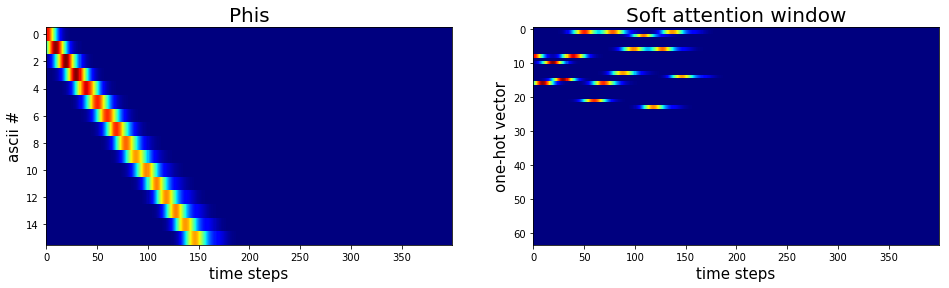

Epoch :  0  - step  10 / 548  - loss  1016.4841918945312  in  12.606544733047485
Epoch :  0  - step  20 / 548  - loss  715.3097534179688  in  12.350513935089111
Epoch :  0  - step  30 / 548  - loss  490.5433044433594  in  12.03981614112854
Epoch :  0  - step  40 / 548  - loss  363.90362548828125  in  11.47139573097229
Epoch :  0  - step  50 / 548  - loss  329.92242431640625  in  11.479313135147095
Epoch :  0  - step  60 / 548  - loss  278.9850158691406  in  11.51031494140625
Epoch :  0  - step  70 / 548  - loss  171.3046112060547  in  11.766595602035522
Epoch :  0  - step  80 / 548  - loss  146.6802520751953  in  11.898402452468872
Epoch :  0  - step  90 / 548  - loss  260.4860534667969  in  13.24842882156372
Epoch :  0  - step  100 / 548  - loss  123.35123443603516  in  15.194506883621216
speak - rouse itself and


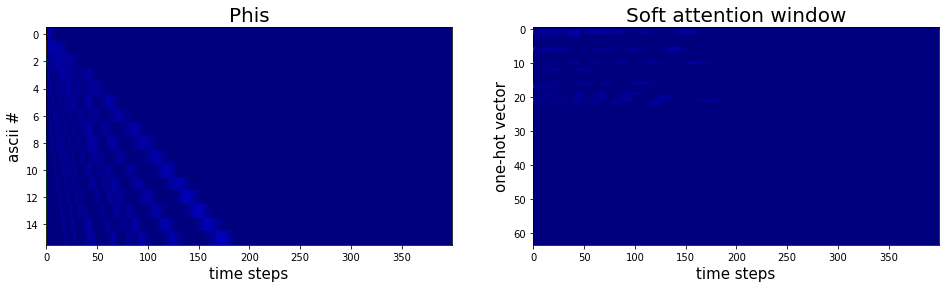

Epoch :  0  - step  110 / 548  - loss  138.85093688964844  in  15.628817558288574
Epoch :  0  - step  120 / 548  - loss  111.97563934326172  in  15.10008955001831
Epoch :  0  - step  130 / 548  - loss  151.76449584960938  in  15.096501111984253
Epoch :  0  - step  140 / 548  - loss  150.8267059326172  in  15.163485527038574
Epoch :  0  - step  150 / 548  - loss  170.9756317138672  in  15.132679462432861
Epoch :  0  - step  160 / 548  - loss  194.648193359375  in  15.23293137550354
Epoch :  0  - step  170 / 548  - loss  42.53719711303711  in  15.08704948425293
Epoch :  0  - step  180 / 548  - loss  127.6912612915039  in  15.095948219299316
Epoch :  0  - step  190 / 548  - loss  78.5030746459961  in  15.130195617675781
Epoch :  0  - step  200 / 548  - loss  125.31031799316406  in  15.114904165267944
if Western Governments had not


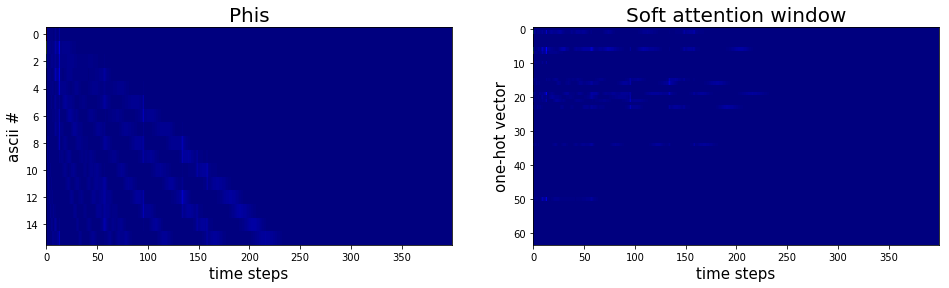

Epoch :  0  - step  210 / 548  - loss  171.15997314453125  in  15.703819751739502
Epoch :  0  - step  220 / 548  - loss  53.918609619140625  in  15.133830547332764
Epoch :  0  - step  230 / 548  - loss  77.2462387084961  in  15.22668743133545
Epoch :  0  - step  240 / 548  - loss  18.161579132080078  in  15.186469316482544
Epoch :  0  - step  250 / 548  - loss  51.59297561645508  in  15.079610109329224
Epoch :  0  - step  260 / 548  - loss  24.524145126342773  in  15.071300506591797
Epoch :  0  - step  270 / 548  - loss  85.10042572021484  in  15.248963356018066
Epoch :  0  - step  280 / 548  - loss  48.06629180908203  in  15.07395339012146
Epoch :  0  - step  290 / 548  - loss  60.733070373535156  in  15.103058338165283
Epoch :  0  - step  300 / 548  - loss  67.9410171508789  in  15.140619039535522
gave others a feeling of # danger.


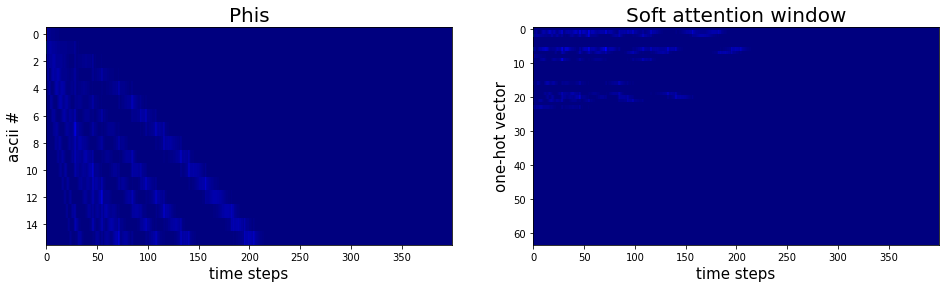

Epoch :  0  - step  310 / 548  - loss  92.81673431396484  in  16.648422956466675
Epoch :  0  - step  320 / 548  - loss  65.39562225341797  in  16.293272733688354
Epoch :  0  - step  330 / 548  - loss  98.6902847290039  in  15.102979898452759
Epoch :  0  - step  340 / 548  - loss  4.1839423179626465  in  15.846673488616943
Epoch :  0  - step  350 / 548  - loss  63.95528030395508  in  15.456194877624512
Epoch :  0  - step  360 / 548  - loss  26.56595802307129  in  15.103122234344482
Epoch :  0  - step  370 / 548  - loss  81.64466857910156  in  15.138432264328003
Epoch :  0  - step  380 / 548  - loss  102.76910400390625  in  15.17670202255249
Epoch :  0  - step  390 / 548  - loss  11.892127990722656  in  16.403001070022583
Epoch :  0  - step  400 / 548  - loss  43.26521682739258  in  15.539434432983398
don't you?" John gave a short


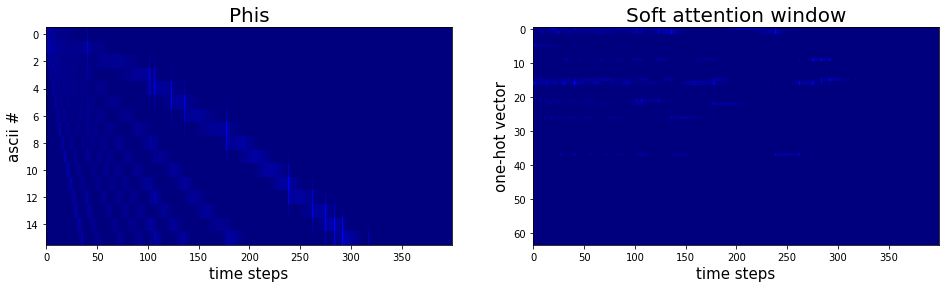

Epoch :  0  - step  410 / 548  - loss  88.40650939941406  in  15.99621319770813
Epoch :  0  - step  420 / 548  - loss  -24.27048110961914  in  16.5094256401062
Epoch :  0  - step  430 / 548  - loss  73.83502960205078  in  16.34852123260498
Epoch :  0  - step  440 / 548  - loss  73.7048568725586  in  15.847392082214355
Epoch :  0  - step  450 / 548  - loss  54.152099609375  in  15.745084285736084
Epoch :  0  - step  460 / 548  - loss  13.803888320922852  in  15.983418941497803
Epoch :  0  - step  470 / 548  - loss  8.142077445983887  in  16.439083576202393
Epoch :  0  - step  480 / 548  - loss  68.31924438476562  in  15.131803035736084
Epoch :  0  - step  490 / 548  - loss  39.1013298034668  in  15.949872732162476
Epoch :  0  - step  500 / 548  - loss  10.835250854492188  in  15.560272932052612
mooring-hook - practically


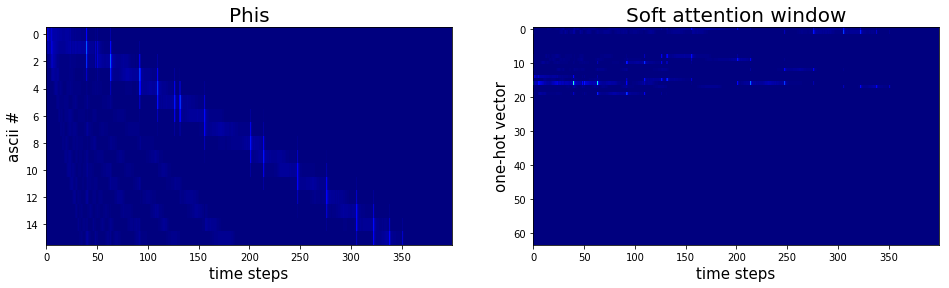

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


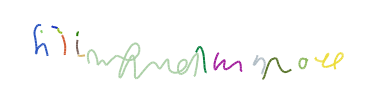

Epoch :  0  - step  510 / 548  - loss  20.289562225341797  in  165.14559936523438
Epoch :  0  - step  520 / 548  - loss  8.989580154418945  in  15.659212589263916
Epoch :  0  - step  530 / 548  - loss  15.1603364944458  in  15.884172677993774
Epoch :  0  - step  540 / 548  - loss  10.582877159118652  in  15.956552028656006
pointer reset
Epoch :  1  - step  0 / 548  - loss  -36.54835891723633  in  13.653106689453125
developed into quite an


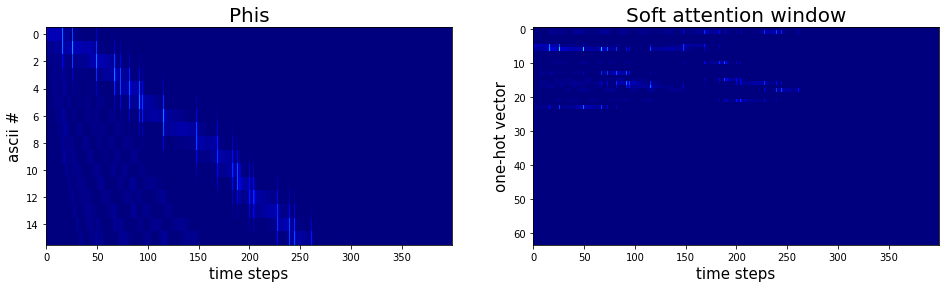

Epoch :  1  - step  10 / 548  - loss  24.044187545776367  in  17.74514079093933
Epoch :  1  - step  20 / 548  - loss  -16.203344345092773  in  16.942505836486816
Epoch :  1  - step  30 / 548  - loss  -13.288790702819824  in  15.476606369018555
Epoch :  1  - step  40 / 548  - loss  -44.1198844909668  in  16.59248995780945
Epoch :  1  - step  50 / 548  - loss  -20.328222274780273  in  15.239674091339111
Epoch :  1  - step  60 / 548  - loss  -46.68708419799805  in  15.262080669403076
Epoch :  1  - step  70 / 548  - loss  -4.0437798500061035  in  15.101358890533447
Epoch :  1  - step  80 / 548  - loss  18.66890525817871  in  18.22193431854248
Epoch :  1  - step  90 / 548  - loss  45.90930938720703  in  23.930701971054077
Epoch :  1  - step  100 / 548  - loss  -39.12712478637695  in  22.348836183547974
he could be wrong. He lit a cigarette, and put


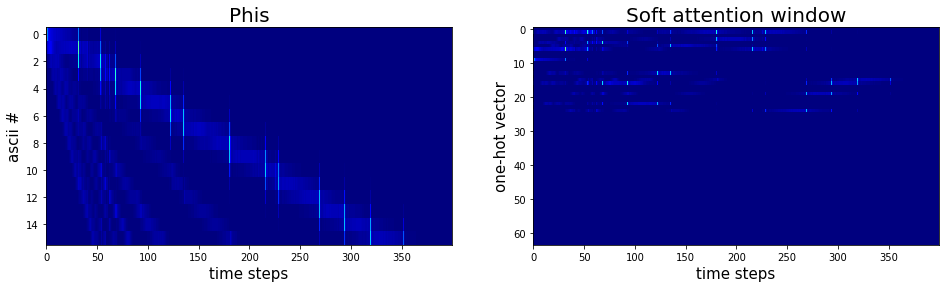

Epoch :  1  - step  110 / 548  - loss  -60.70459747314453  in  23.813727617263794
Epoch :  1  - step  120 / 548  - loss  -46.21085739135742  in  22.64996099472046
Epoch :  1  - step  130 / 548  - loss  -40.38425064086914  in  22.436511993408203
Epoch :  1  - step  140 / 548  - loss  27.951309204101562  in  28.764997243881226
Epoch :  1  - step  150 / 548  - loss  -3.411558151245117  in  22.3410964012146
Epoch :  1  - step  160 / 548  - loss  4.0739827156066895  in  23.49612045288086
Epoch :  1  - step  170 / 548  - loss  2.0295770168304443  in  22.69934058189392
Epoch :  1  - step  180 / 548  - loss  -59.4298095703125  in  24.440061330795288
Epoch :  1  - step  190 / 548  - loss  -132.40673828125  in  23.62753653526306
Epoch :  1  - step  200 / 548  - loss  -47.82090377807617  in  22.60642385482788
were! Trying to win your way into


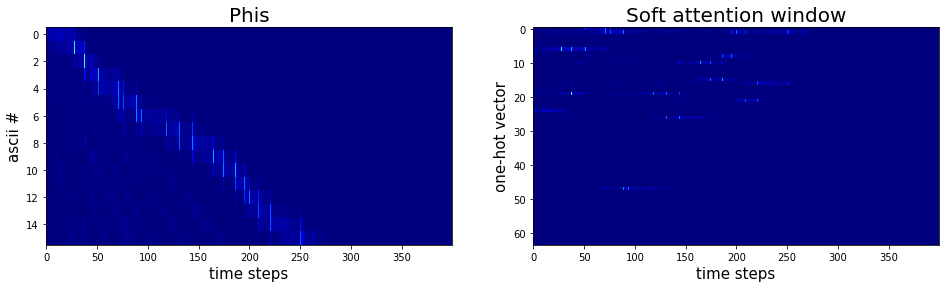

Epoch :  1  - step  210 / 548  - loss  -1.563636064529419  in  23.378219842910767
Epoch :  1  - step  220 / 548  - loss  -36.7177848815918  in  23.716280698776245
Epoch :  1  - step  230 / 548  - loss  -71.8765869140625  in  24.349666357040405
Epoch :  1  - step  240 / 548  - loss  -101.823486328125  in  22.76447367668152
Epoch :  1  - step  250 / 548  - loss  -23.657766342163086  in  22.746062994003296
Epoch :  1  - step  260 / 548  - loss  -56.10200119018555  in  22.493106365203857
Epoch :  1  - step  270 / 548  - loss  -89.6369857788086  in  22.85070562362671
Epoch :  1  - step  280 / 548  - loss  -48.3854866027832  in  22.41365885734558
Epoch :  1  - step  290 / 548  - loss  -13.478095054626465  in  23.4318265914917
Epoch :  1  - step  300 / 548  - loss  12.311769485473633  in  22.77866554260254
her State of health ". It is not


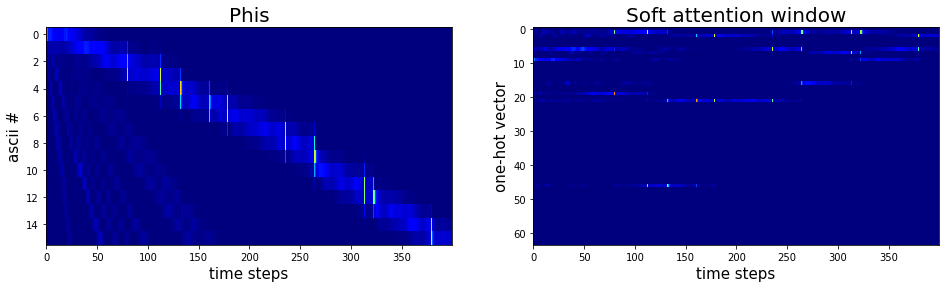

Epoch :  1  - step  310 / 548  - loss  -44.59309387207031  in  23.707828044891357
Epoch :  1  - step  320 / 548  - loss  -35.10810470581055  in  23.261078357696533
Epoch :  1  - step  330 / 548  - loss  -7.463981628417969  in  23.121957778930664
Epoch :  1  - step  340 / 548  - loss  -66.87409210205078  in  22.400193452835083
Epoch :  1  - step  350 / 548  - loss  75.85820007324219  in  22.528573274612427
Epoch :  1  - step  360 / 548  - loss  -68.8837890625  in  22.39319086074829
Epoch :  1  - step  370 / 548  - loss  -59.57400131225586  in  22.610738277435303
Epoch :  1  - step  380 / 548  - loss  -84.9597396850586  in  22.506522178649902
Epoch :  1  - step  390 / 548  - loss  -49.749061584472656  in  23.123559951782227
Epoch :  1  - step  400 / 548  - loss  -146.10618591308594  in  22.7695791721344
took place, demonstrations, social events


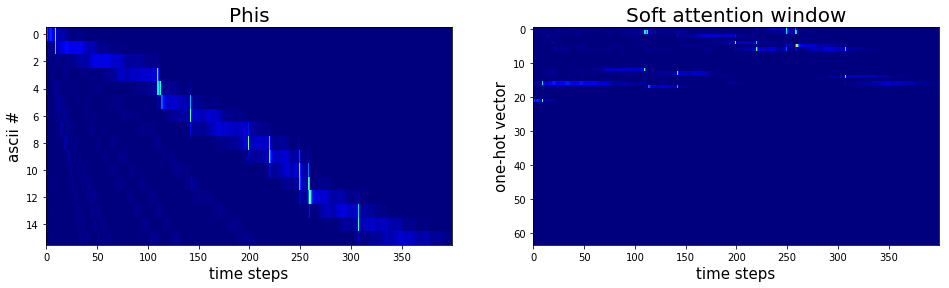

Epoch :  1  - step  410 / 548  - loss  -2.647770643234253  in  23.330405473709106
Epoch :  1  - step  420 / 548  - loss  -57.6126708984375  in  22.63660192489624
Epoch :  1  - step  430 / 548  - loss  -90.73797607421875  in  22.4115993976593
Epoch :  1  - step  440 / 548  - loss  -87.02684020996094  in  22.507729053497314
Epoch :  1  - step  450 / 548  - loss  -67.05137634277344  in  22.550959587097168
Epoch :  1  - step  460 / 548  - loss  -9.295611381530762  in  22.437475442886353
Epoch :  1  - step  470 / 548  - loss  -65.56934356689453  in  22.75451970100403
Epoch :  1  - step  480 / 548  - loss  -55.41594314575195  in  23.131601095199585
Epoch :  1  - step  490 / 548  - loss  57.61555862426758  in  22.793291568756104
Epoch :  1  - step  500 / 548  - loss  -35.457191467285156  in  23.14594578742981
enhanced when he dug out A PACKET of


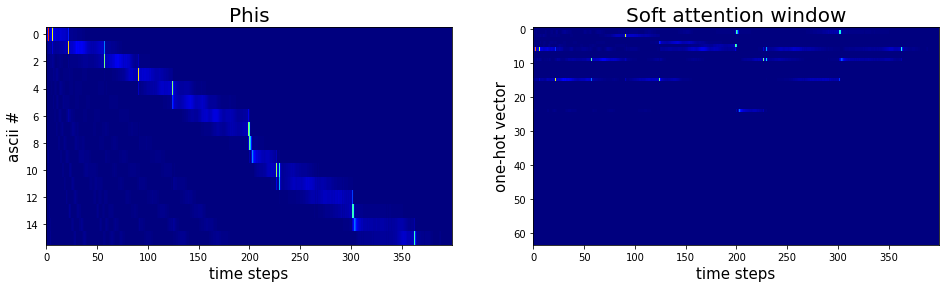

Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


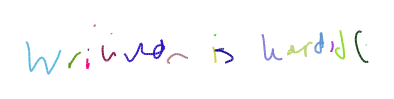

Epoch :  1  - step  510 / 548  - loss  -9.297953605651855  in  236.77724504470825


KeyboardInterrupt: 

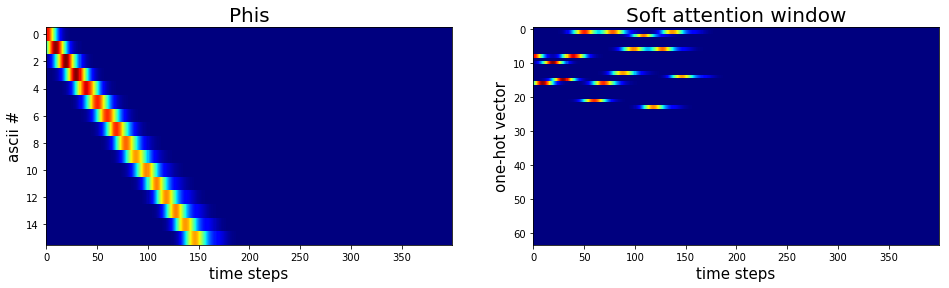

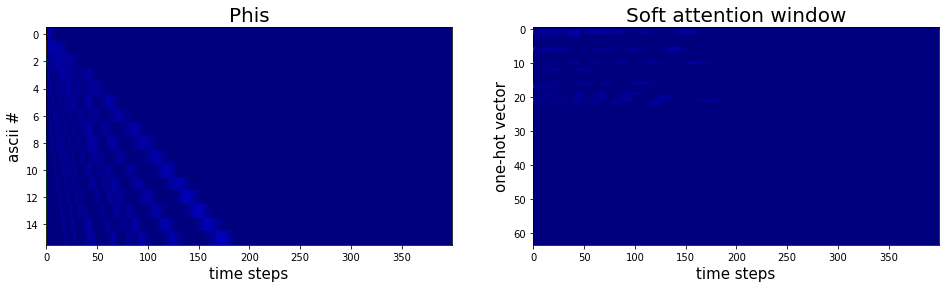

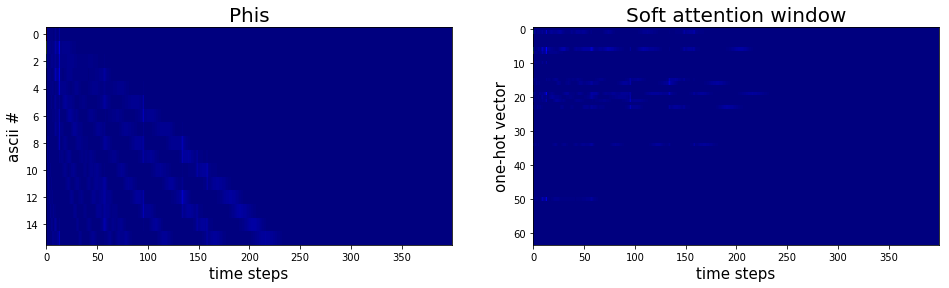

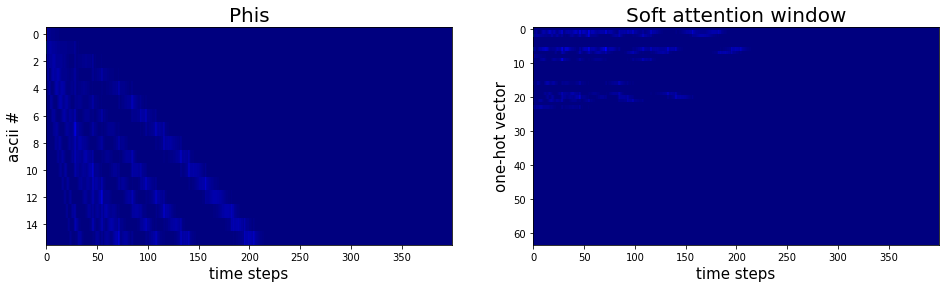

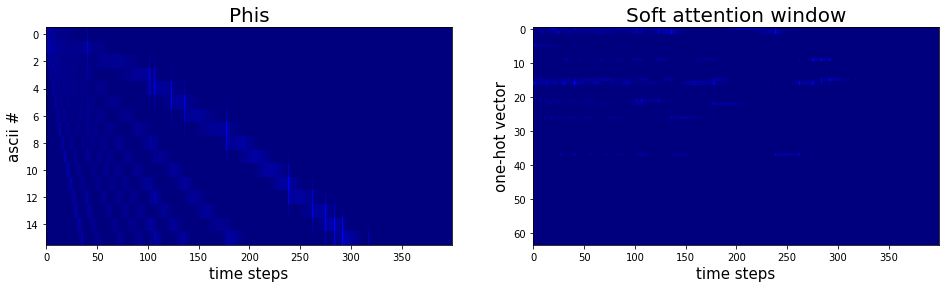

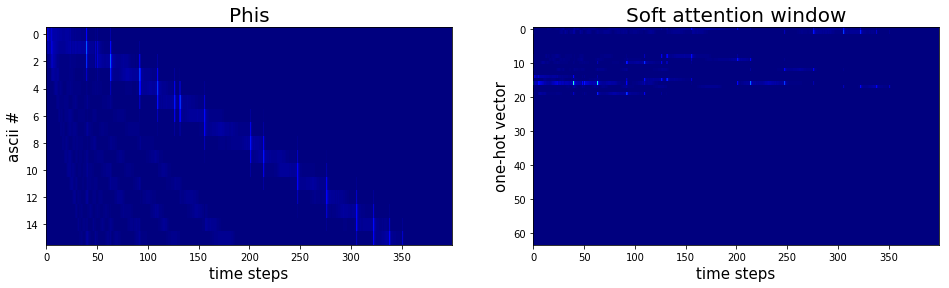

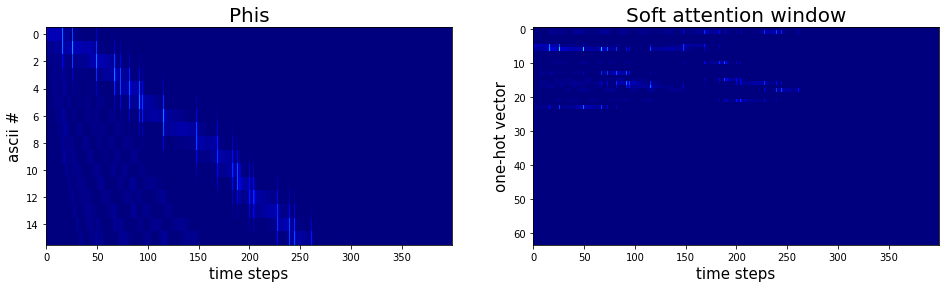

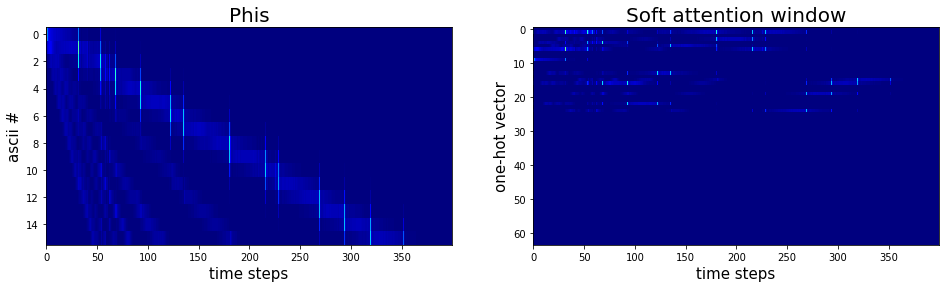

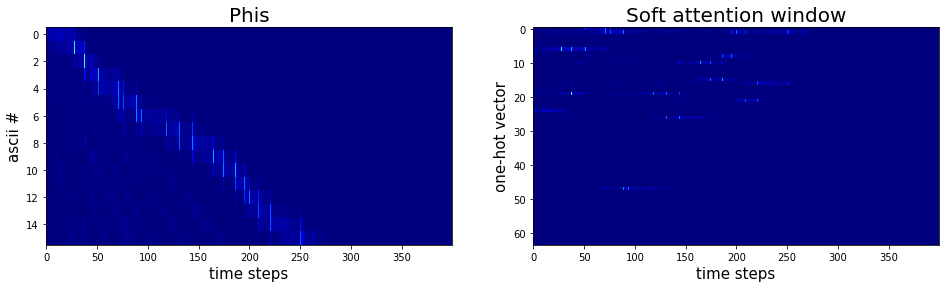

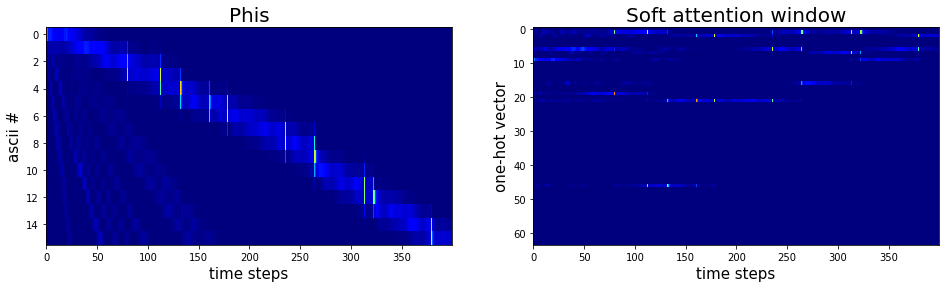

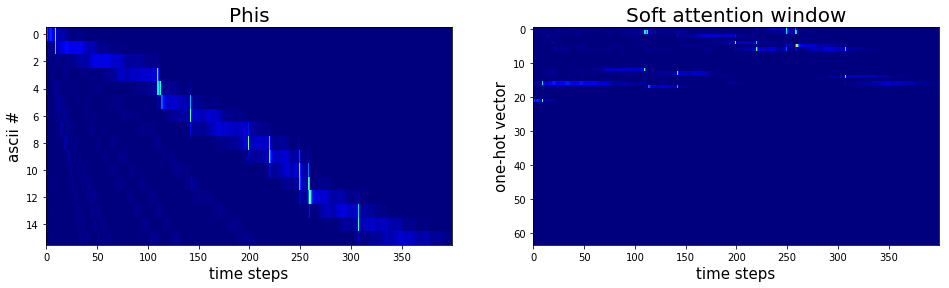

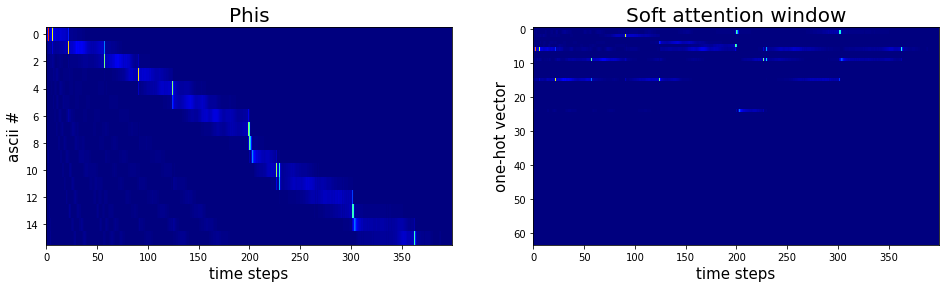

In [8]:
torch.cuda.empty_cache()
model = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

model = train_network(model, epochs = 50, generate = True)




## Test cell

```Python
torch.cuda.empty_cache()

modelTest = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
x, y, s, c = data_loader.next_batch()
x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
c = np.float32(np.array(c))

x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    modelTest = modelTest.cuda()
    x = x.cuda()
    y = y.cuda()
    c = c.cuda()

es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos, Phis, Ws = modelTest.forward(x, c)


Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
loss = loss_fn(Pr,y, es)

test = one_hot("Will it ever work ?")

x0 = torch.Tensor([0,0,1]).view(1,1,3)
c0 = np.float32(one_hot("Laurent estun PD"))
c0 = torch.from_numpy(c0) 
c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    x0 = x0.cuda()

sequence = model.generate_sequence(x0, c0)
print(sequence.shape)
draw_strokes_random_color(sequence, factor=0.5)
```